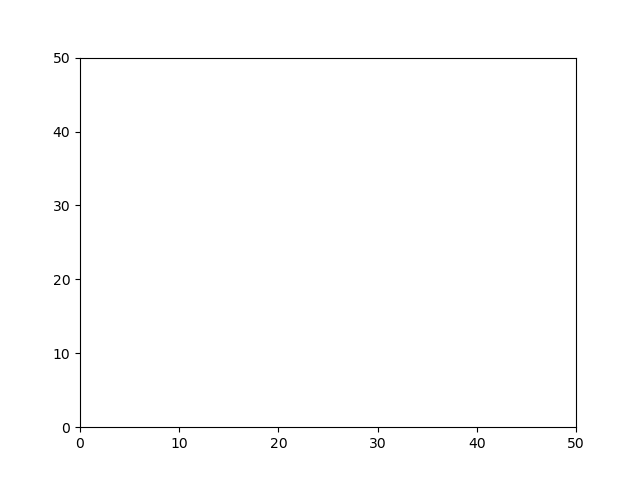

In [3]:


%matplotlib ipympl
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Box dimensions
box_size = 50

# Number of particles
num_particles = 4
particle_radius = 1.0  # Radius of the particles
large_num = 1000  # A large number for no collision

# Time parameters
t_max = 100 # Total simulation time
dt = 0.1     # Time step

# Initialize positions and velocities
np.random.seed(0)  # For reproducibility
positions = np.array([[10.0, 20.0],[13, 20.0],[37, 20.0],[40.0, 20]])
velocities = np.array([[1.5, 0],[1.5, 0],[-1.5, 0.0],[-1.5, 0.0]])

# Function to compute the time to the first collision between two particles
def particle_collision_time(pos_i, vel_i, pos_j, vel_j):
    delta_x = pos_j[0] - pos_i[0]
    delta_vx = vel_j[0] - vel_i[0]
    delta_y = pos_j[1] - pos_i[1]
    delta_vy = vel_j[1] - vel_i[1]
    #print(f'delta_x:{delta_x}, delta_y:{delta_y}, delta_vy:{delta_vy}, delta_vx:{delta_vx}')
    a = delta_vx**2 + delta_vy**2
    b = 2 * (delta_x * delta_vx + delta_y * delta_vy)
    c = delta_x**2 + delta_y**2 - 4 * particle_radius**2  # Adjusting for radius
    
    if a == 0:
        return large_num  # Particles moving parallel (no collision)
    
    Delta = b**2 - 4 * a * c
    if Delta < 0:
        return large_num  # No real roots, no collision
    elif Delta == 0:
        t = -b / (2 * a)
        return t if t >= 0 else large_num
    else:
        t1 = (-b + math.sqrt(Delta)) / (2 * a)
        t2 = (-b - math.sqrt(Delta)) / (2 * a)
        if t1 >= 0 and t2 >= 0:
            #print(f'delta>0 and {t1} and {t2}')
            return min(t1, t2)
        elif t1 >= 0:
            return t1
        elif t2 >= 0:
            return t2
        return large_num

# Function to compute the time to collision with the walls
def wall_collision_time(position, velocity):
    times = []
    for i in range(2):  # x and y directions
        if velocity[i] > 0:
            t_wall = (box_size - particle_radius - position[i]) / velocity[i]
        elif velocity[i] < 0:
            t_wall = (particle_radius - position[i]) / velocity[i]
        else:
            t_wall = large_num  # No movement in this direction
        times.append(t_wall)
    
    return min(times)

# Function to find the next collision event
def find_earliest_collision(positions, velocities):
    min_time = large_num
    collision_pair = (-1, -1)  # (-1, -1) means wall collision
    
    # Check particle-particle collisions
    for i in range(num_particles):
        for j in range(i + 1, num_particles):
            t_collision = particle_collision_time(positions[i], velocities[i], positions[j], velocities[j])
            if t_collision < min_time:
                min_time = t_collision
                #print(min_time)
                collision_pair = (i, j)
    
    # Check particle-wall collisions
    for i in range(num_particles):
        t_wall = wall_collision_time(positions[i], velocities[i])
        if t_wall < min_time:
            min_time = t_wall
            collision_pair = (i, -1)  # Indicate wall collision for this particle
    
    return min_time, collision_pair
def update_positions(positions, velocities, dt):
    # Update positions
    positions += velocities * dt
    
    #print(positions)
    # Check for boundary collisions and reflect velocities
    for i in range(num_particles):
        for j in range(2):  # x and y directions
            if positions[i, j] <= particle_radius or positions[i, j] >= box_size - particle_radius:
                velocities[i, j] *= -1
                
                #pressure += 1
                positions[i, j] = np.clip(positions[i, j], particle_radius, box_size - particle_radius)
                #print(f'wall collision for {i} at {dt}s and position:{positions[i]}')
                #print(f'({i}, {j})position of wall colision {positions[i]} and new v:{velocities[i]}')
    # Check for particle collisions
    for i in range(num_particles):
        for j in range(i + 1, num_particles):
            dist = np.linalg.norm(positions[i] - positions[j])
            if dist <= 2 * particle_radius:  # Collision condition
                #print(f'for {i}, {j} we have a collision at position{positions[i]} and {positions[j]}')
                resolve_collision(i, j, positions, velocities)
    positions += velocities * 0.00000001
    
    return positions
# Function to resolve the collision (particles or walls)
def resolve_collision(i, j, positions, velocities):
    # Calculate the normal vector
    delta_pos = positions[i] - positions[j]
    dist = np.linalg.norm(delta_pos)
    delta_v = velocities[i] - velocities[j]
    # Normal vector
    n_hat = delta_pos / (dist**2)
    
    # Relative velocity
    
    
    # Velocity component along the normal direction
    v_rel = np.dot(delta_v, delta_pos)
    
    # Update velocities if particles are moving towards each other
    if v_rel < 0:
        velocities[i] -= v_rel * n_hat
        velocities[j] += v_rel * n_hat
    #print(f'({i},{j}) new i: p:{positions[i]}, v:{velocities[i]}\n and j: p:{positions[j]},v:{velocities[j]}')
    

# t = 0
# while t < t_max:
#     delta_t, collision_pair = find_earliest_collision(positions, velocities)
#     print(f'delta t is {delta_t}')
#     positions = update_positions(positions, velocities, delta_t)
#     t += (delta_t +0.00000001)
#     print(f'delta t is {delta_t}')
    
#Visualization setup
fig, ax = plt.subplots()
ax.set_xlim(0, box_size)
ax.set_ylim(0, box_size)
particles, = ax.plot([], [], 'bo', ms=10)

def init():
    particles.set_data([], [])
    return particles,

def animate(frame):
    global positions, velocities, dt
    
    # Find the earliest collision
    delta_t, collision_pair = find_earliest_collision(positions, velocities)
    
    # Update positions to the collision time
    if delta_t < dt:
        positions = update_positions(positions, velocities, delta_t)
        # positions += velocities * delta_t
        #print(f'colision pair is {collision_pair}')
        #print(delta_t)
        # #print(f'delta t is {delta_t} and poistions {positions}')
        # resolve_collision(collision_pair, positions, velocities)
        # #positions += velocities * 0.001
        # #t += (delta_t + 0.01)
        # #print(f'delta t is {delta_t}')
        dt -= (delta_t + 0.00000001)
    else:
        positions = update_positions(positions, velocities, dt)
        dt = 0.1  # Reset time step after each update
    
    particles.set_data(positions[:, 0], positions[:, 1])
    return particles,

# Animation
ani = animation.FuncAnimation(fig, animate, frames=int(t_max/dt), init_func=init,
                              interval=20, blit=True, repeat=False)

plt.show()


In [3]:
print(positions)

[[  18.4   20. ]
 [  19.4   20. ]
 [-257.4   20. ]
 [-256.4   20. ]]


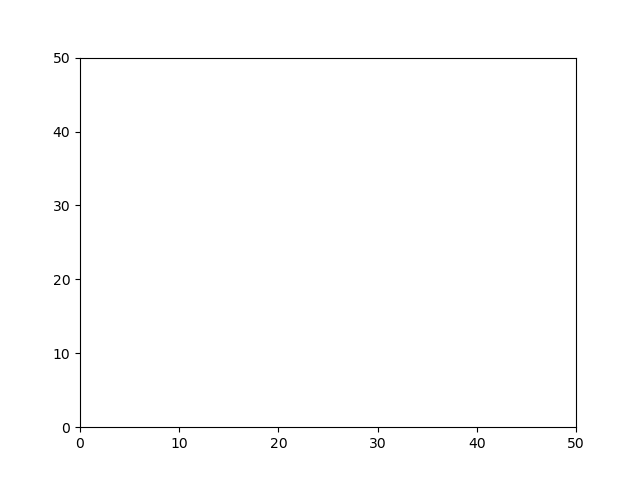

In [21]:
%matplotlib ipympl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Box dimensions
box_size = 50

# Number of particles
num_particles = 4
particle_radius = 1.0  # Radius of the particles
large_num = 1000  # A large number for no collision

# Time parameters
t_max = 100 # Total simulation time
dt = 0.05    # Time step

# Initialize positions and velocities
np.random.seed(0)  # For reproducibility
positions = np.array([[10.0, 20.0],[14, 20.0],[36, 20.0],[40.0, 20]])
velocities = np.array([[2.0, 0],[2.0, 0],[-2.0, 0.0],[-2.0, 0.0]])

Temp = np.mean(velocities[:,0]**2 + velocities[:,1]**2)
pressure = 0
large_num = 100
import math
# def particle_colision_time(position_i, V_i, positin_j, V_j):
#     delta_x = positin_j[0] - position_i[0]
#     delta_vx = V_j[0] - V_i[0]
#     delta_y = positin_j[1] - position_i[1]
#     delta_yv = V_j[1] - V_i[1]
#     # The colision equation is: (\delta_vx^2 + \delta_vy^2)*t^2 + (2\deltax*\delta_vx + 2*\deltay*\delta_vy)*t + (\deltax^2 + \deltay^2) = 4
#     # ax^2 + bx + c = 0
#     a = delta_vx**2 + delta_yv**2
#     b = 2 * (delta_x * delta_vx + delta_y * delta_yv)
#     c = delta_x**2 + delta_y**2 - particle_radius
#     Delta = b**2 - 4 * a * c
#     if a == 0:
#         return large_num
#     if Delta < 0:
#         return large_num
#     elif Delta == 0:
#         t = -1 * b / (2 * a)
#         if t >= 0:
#             return t
#         else:
#             return large_num
#     else:
#         t1 = (-1 * b + math.sqrt(Delta)) / (2 * a)
#         t2 = (-1 * b - math.sqrt(Delta)) / (2 * a)
#         if t1 < 0 and t2 < 0:
#             # print('colision occured in negative time')
#             return large_num
#         elif t1 < 0 and t2 >= 0:
#             return t2
#         elif t2 < 0 and t1 >= 0:
#             return t1
#         elif t2 >= 0 and t1 >= 0:
#             # print(f'were here and t1:{t1} and t2:{t2}' )
#             return min(t1, t2)
colors = ['r', 'g', 'b', 'm'] 
# Function to update positions and velocities
def update_positions(positions, velocities, dt):
    # Update positions
    positions += velocities * dt
    
    # Check for boundary collisions and reflect velocities
    for i in range(num_particles):
        for j in range(2):  # x and y directions
            if positions[i, j] <= particle_radius or positions[i, j] >= box_size - particle_radius:
                velocities[i, j] *= -1
                #pressure += 1
                positions[i, j] = np.clip(positions[i, j], particle_radius, box_size - particle_radius)
                #print(f'({i}, {j})position of wall colision {positions[i]} and new v:{velocities[i]}')
    # Check for particle collisions
    for i in range(num_particles):
        for j in range(i + 1, num_particles):
            dist = np.linalg.norm(positions[i] - positions[j])
            if dist < 2 * particle_radius:  # Collision condition
                resolve_collision(i, j, positions, velocities)
    
    return positions

# Function to resolve elastic collision between two particles
def resolve_collision(i, j, positions, velocities):
    # Calculate the normal vector
    delta_pos = positions[i] - positions[j]
    dist = np.linalg.norm(delta_pos)
    
    # Normal vector
    n_hat = delta_pos / dist
    
    # Relative velocity
    delta_v = velocities[i] - velocities[j]
    
    # Velocity component along the normal direction
    v_rel = np.dot(delta_v, n_hat)
    
    # Update velocities if particles are moving towards each other
    if v_rel < 0:
        velocities[i] -= v_rel * n_hat
        velocities[j] += v_rel * n_hat
    #print(f'({i},{j}) new i: p:{positions[i]}, v:{velocities[i]}\n and j: p:{positions[j]},v:{velocities[j]}')

# Visualization setup
fig, ax = plt.subplots()
ax.set_xlim(0, box_size)
ax.set_ylim(0, box_size)
particles = [ax.plot([], [], 'o', color=colors[i], ms=10)[0] for i in range(num_particles)]


def init():
    for particle in particles:
        particle.set_data([], [])
    return particles

def animate(frame):
    global positions
    
    positions = update_positions(positions, velocities, dt)
    # Update the positions of the particles
    for i, particle in enumerate(particles):
        particle.set_data(positions[i, 0], positions[i, 1])
    return particles,

# Animation
ani = animation.FuncAnimation(fig, animate, frames=int(t_max/dt), init_func=init,
                              interval=20, blit=True, repeat=False)

plt.show()


    

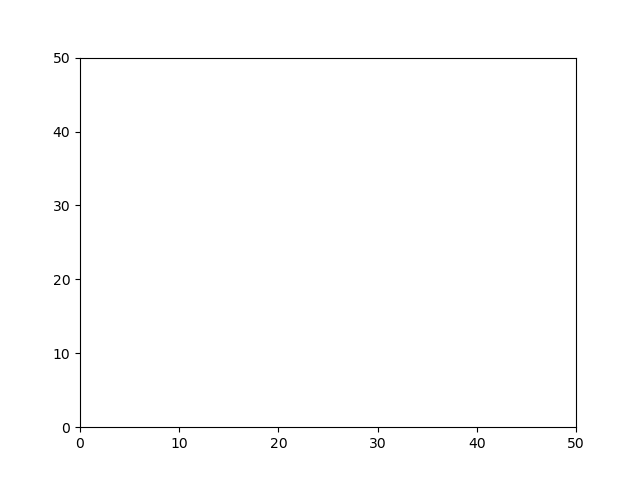

In [5]:
%matplotlib ipympl
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Box dimensions
box_size = 50

# Number of particles
num_particles = 4
particle_radius = 1.0  # Radius of the particles
large_num = 1000  # A large number for no collision

# Time parameters
t_max = 100 # Total simulation time
dt = 0.1     # Time step

# Initialize positions and velocities
np.random.seed(0)  # For reproducibility
positions = np.array([[10.0, 20.0],[12, 20.0],[38, 20.0],[40.0, 20]])
velocities = np.array([[3.0, 0],[3.0, 0],[-3.0, 0.0],[-3.0, 0.0]]) # random velocities between (-1, 1)

# Function to compute the time to the first collision between two particles
def particle_collision_time(pos_i, vel_i, pos_j, vel_j):
    delta_x = pos_j[0] - pos_i[0]
    delta_vx = vel_j[0] - vel_i[0]
    delta_y = pos_j[1] - pos_i[1]
    delta_vy = vel_j[1] - vel_i[1]
    
    a = delta_vx**2 + delta_vy**2
    b = 2 * (delta_x * delta_vx + delta_y * delta_vy)
    c = delta_x**2 + delta_y**2 - 4 * particle_radius**2  # Adjusting for radius
    
    if a == 0:
        return large_num  # Particles moving parallel (no collision)
    
    Delta = b**2 - 4 * a * c
    if Delta < 0:
        return large_num  # No real roots, no collision
    elif Delta == 0:
        t = -b / (2 * a)
        return t if t >= 0 else large_num
    else:
        t1 = (-b + math.sqrt(Delta)) / (2 * a)
        t2 = (-b - math.sqrt(Delta)) / (2 * a)
        if t1 >= 0 and t2 >= 0:
            return min(t1, t2)
        elif t1 >= 0:
            return t1
        elif t2 >= 0:
            return t2
        return large_num

# Function to compute the time to collision with the walls
def wall_collision_time(position, velocity):
    times = []
    for i in range(2):  # x and y directions
        if velocity[i] > 0:
            t_wall = (box_size - particle_radius - position[i]) / velocity[i]
        elif velocity[i] < 0:
            t_wall = (particle_radius - position[i]) / velocity[i]
        else:
            t_wall = large_num  # No movement in this direction
        times.append(t_wall)
    
    return min(times)

# Function to find the next collision event
def find_earliest_collision(positions, velocities):
    min_time = large_num
    collision_pair = (-1, -1)  # (-1, -1) means wall collision
    
    # Check particle-particle collisions
    for i in range(num_particles):
        for j in range(i + 1, num_particles):
            t_collision = particle_collision_time(positions[i], velocities[i], positions[j], velocities[j])
            if t_collision < min_time:
                min_time = t_collision
                collision_pair = (i, j)
    
    # Check particle-wall collisions
    for i in range(num_particles):
        t_wall = wall_collision_time(positions[i], velocities[i])
        if t_wall < min_time:
            min_time = t_wall
            collision_pair = (i, -1)  # Indicate wall collision for this particle
    
    return min_time, collision_pair

# Function to resolve the collision (particles or walls)
def resolve_collision(collision_pair, positions, velocities):
    i, j = collision_pair
    if j == -1:  # Wall collision
        if positions[i][0] <= particle_radius or positions[i][0] >= box_size - particle_radius:
            velocities[i][0] *= -1  # Reverse x-velocity
        if positions[i][1] <= particle_radius or positions[i][1] >= box_size - particle_radius:
            velocities[i][1] *= -1  # Reverse y-velocity
        #print(f'({i}, {j})position of wall colision {positions[i]} and new v:{velocities[i]}')
    else:  # Particle-particle collision
        delta_pos = positions[i] - positions[j]
        dist = np.linalg.norm(delta_pos)
        n_hat = delta_pos / dist
        delta_v = velocities[i] - velocities[j]
        v_rel = np.dot(delta_v, n_hat)
        
        if v_rel < 0:  # Only resolve if they are moving towards each other
            velocities[i] -= v_rel * n_hat
            velocities[j] += v_rel * n_hat
        #print(f'({i}, {j}) new i: p:{positions[i]}, v:{velocities[i]}\n and j: p:{positions[j]},v:{velocities[j]}')
    

#t = 0
# while t < t_max:
#     delta_t, collision_pair = find_earliest_collision(positions, velocities)
#     positions += velocities * delta_t
#     resolve_collision(collision_pair, positions, velocities)
#     positions += velocities * 0.01
#     t += (delta_t + 0.01)
#     print(f'delta t is {delta_t}')
# Visualization setup
fig, ax = plt.subplots()
ax.set_xlim(0, box_size)
ax.set_ylim(0, box_size)
particles, = ax.plot([], [], 'bo', ms=10)

def init():
    particles.set_data([], [])
    return particles,

def animate(frame):
    global positions, velocities, dt
    
    # Find the earliest collision
    delta_t, collision_pair = find_earliest_collision(positions, velocities)
    
    # Update positions to the collision time
    if delta_t < dt:
        
        positions += velocities * delta_t
        resolve_collision(collision_pair, positions, velocities)
        #positions += velocities * 0.001
        #t += (delta_t + 0.01)
        #print(f'delta t is {delta_t}')
        dt -= delta_t
    else:
        positions += velocities * dt
        dt = 0.1  # Reset time step after each update
    
    particles.set_data(positions[:, 0], positions[:, 1])
    return particles,

# Animation
ani = animation.FuncAnimation(fig, animate, frames=int(t_max/dt), init_func=init,
                              interval=20, blit=True, repeat=False)

plt.show()

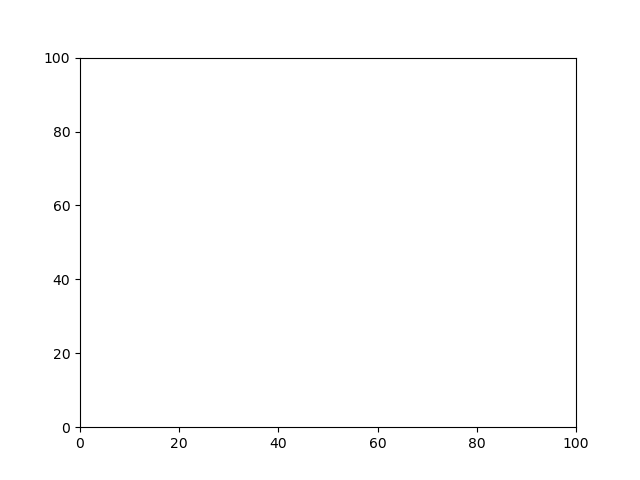

In [4]:


%matplotlib ipympl
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Box dimensions
box_size = 100

# Number of particles
num_particles = 4
particle_radius = 2.0  # Radius of the particles
large_num = 1000  # A large number for no collision

# Time parameters
t_max = 100 # Total simulation time
dt = 0.1     # Time step

# Initialize positions and velocities
np.random.seed(0)  # For reproducibility
positions = np.array([[10.0, 10.0],[19, 9.0],[40, 40.0],[36.0, 40]])
velocities = np.array([[1.5, 1.5],[-3, 0],[-1.5, 0.0],[-1.5, 0.0]])

# Function to compute the time to the first collision between two particles
def particle_collision_time(pos_i, vel_i, pos_j, vel_j):
    delta_x = pos_j[0] - pos_i[0]
    delta_vx = vel_j[0] - vel_i[0]
    delta_y = pos_j[1] - pos_i[1]
    delta_vy = vel_j[1] - vel_i[1]
    #print(f'delta_x:{delta_x}, delta_y:{delta_y}, delta_vy:{delta_vy}, delta_vx:{delta_vx}')
    a = delta_vx**2 + delta_vy**2
    b = 2 * (delta_x * delta_vx + delta_y * delta_vy)
    c = delta_x**2 + delta_y**2 - 4 * particle_radius**2  # Adjusting for radius
    
    if a == 0:
        return large_num  # Particles moving parallel (no collision)
    
    Delta = b**2 - 4 * a * c
    if Delta < 0:
        return large_num  # No real roots, no collision
    elif Delta == 0:
        t = -b / (2 * a)
        return t if t >= 0 else large_num
    else:
        t1 = (-b + math.sqrt(Delta)) / (2 * a)
        t2 = (-b - math.sqrt(Delta)) / (2 * a)
        if t1 >= 0 and t2 >= 0:
            #print(f'delta>0 and {t1} and {t2}')
            return min(t1, t2)
        elif t1 >= 0:
            return t1
        elif t2 >= 0:
            return t2
        return large_num

# Function to compute the time to collision with the walls
def wall_collision_time(position, velocity):
    times = []
    for i in range(2):  # x and y directions
        if velocity[i] > 0:
            t_wall = (box_size - particle_radius - position[i]) / velocity[i]
        elif velocity[i] < 0:
            t_wall = (particle_radius - position[i]) / velocity[i]
        else:
            t_wall = large_num  # No movement in this direction
        times.append(t_wall)
    
    return min(times)

# Function to find the next collision event
def find_earliest_collision(positions, velocities):
    min_time = large_num
    collision_pair = (-1, -1)  # (-1, -1) means wall collision
    
    # Check particle-particle collisions
    for i in range(num_particles):
        for j in range(i + 1, num_particles):
            t_collision = particle_collision_time(positions[i], velocities[i], positions[j], velocities[j])
            if t_collision < min_time:
                min_time = t_collision
                #print(min_time)
                collision_pair = (i, j)
    
    # Check particle-wall collisions
    for i in range(num_particles):
        t_wall = wall_collision_time(positions[i], velocities[i])
        if t_wall < min_time:
            min_time = t_wall
            collision_pair = (i, -1)  # Indicate wall collision for this particle
    
    return min_time, collision_pair
def update_positions(positions, velocities, dt):
    # Update positions
    positions += velocities * dt
    
    #print(positions)
    # Check for boundary collisions and reflect velocities
    for i in range(num_particles):
        for j in range(2):  # x and y directions
            if positions[i, j] <= particle_radius or positions[i, j] >= box_size - particle_radius:
                velocities[i, j] *= -1
                
                #pressure += 1
                positions[i, j] = np.clip(positions[i, j], particle_radius, box_size - particle_radius)
                #print(f'wall collision for {i} at {dt}s and position:{positions[i]}')
                #print(f'({i}, {j})position of wall colision {positions[i]} and new v:{velocities[i]}')
    # Check for particle collisions
    for i in range(num_particles):
        for j in range(i + 1, num_particles):
            dist = np.linalg.norm(positions[i] - positions[j])
            if dist <= 2 * particle_radius:  # Collision condition
                #print(f'for {i}, {j} we have a collision at position{positions[i]} and {positions[j]}')
                resolve_collision(i, j, positions, velocities)
    positions += velocities * 0.00000001
    
    return positions
# Function to resolve the collision (particles or walls)
def resolve_collision(i, j, positions, velocities):
    # Calculate the normal vector
    delta_pos = positions[i] - positions[j]
    dist = np.linalg.norm(delta_pos)
    delta_v = velocities[i] - velocities[j]
    # Normal vector
    n_hat = delta_pos / (dist**2)
    #print(f'dist is {dist}')
    # Relative velocity
    
    
    # Velocity component along the normal direction
    v_rel = np.dot(delta_v, delta_pos)
    
    # Update velocities if particles are moving towards each other
    if v_rel < 0:
        velocities[i] -= v_rel * n_hat
        velocities[j] += v_rel * n_hat
    #print(f'({i},{j}) new i: p:{positions[i]}, v:{velocities[i]}\n and j: p:{positions[j]},v:{velocities[j]}')
    

# t = 0
# while t < t_max:
#     delta_t, collision_pair = find_earliest_collision(positions, velocities)
#     print(f'delta t is {delta_t}')
#     positions = update_positions(positions, velocities, delta_t)
#     t += (delta_t +0.00000001)
#     print(f'delta t is {delta_t}')
    
#Visualization setup
fig, ax = plt.subplots()
ax.set_xlim(0, box_size)
ax.set_ylim(0, box_size)
particles, = ax.plot([], [], 'bo', ms=10)

def init():
    particles.set_data([], [])
    return particles,

def animate(frame):
    global positions, velocities, dt
    
    # Find the earliest collision
    delta_t, collision_pair = find_earliest_collision(positions, velocities)
    
    # Update positions to the collision time
    if delta_t < dt:
        positions = update_positions(positions, velocities, delta_t)
        # positions += velocities * delta_t
        #print(f'colision pair is {collision_pair}')
        #print(delta_t)
        # #print(f'delta t is {delta_t} and poistions {positions}')
        # resolve_collision(collision_pair, positions, velocities)
        # #positions += velocities * 0.001
        # #t += (delta_t + 0.01)
        # #print(f'delta t is {delta_t}')
        dt -= (delta_t + 0.00000001)
    else:
        positions = update_positions(positions, velocities, dt)
        dt = 0.1  # Reset time step after each update
    
    particles.set_data(positions[:, 0], positions[:, 1])
    return particles,

# Animation
ani = animation.FuncAnimation(fig, animate, frames=int(t_max/dt), init_func=init,
                              interval=20, blit=True, repeat=False)

plt.show()


[[10. 10.]
 [90. 90.]]


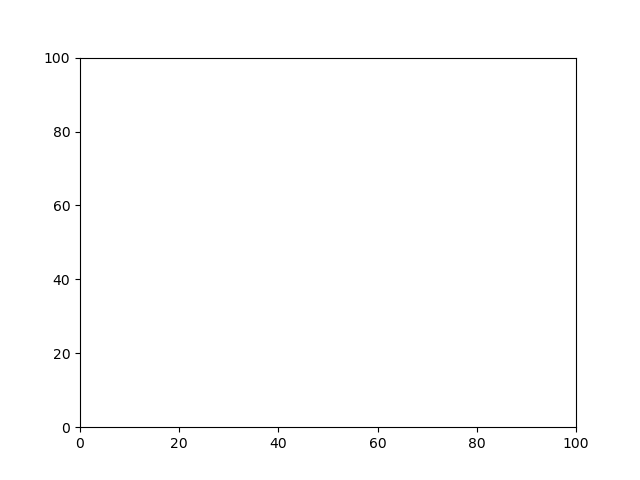

for 0, 1 we have a collision at position[48.58578944 48.58578944] and [51.41421056 51.41421056],dist:3.999991514718629
wall collision for 0 at 0.09024429175122618s and position:[2.       1.999997]
wall collision for 0 at 0.09024429175122618s and position:[2. 2.]
wall collision for 1 at 0.09024429175122618s and position:[98.       98.000003]
wall collision for 1 at 0.09024429175122618s and position:[98. 98.]
for 0, 1 we have a collision at position[48.58578944 48.58578944] and [51.41421056 51.41421056],dist:3.999991514718629
wall collision for 0 at 0.04712725016911429s and position:[2.       1.999997]
wall collision for 0 at 0.04712725016911429s and position:[2. 2.]
wall collision for 1 at 0.04712725016911429s and position:[98.       98.000003]
wall collision for 1 at 0.04712725016911429s and position:[98. 98.]
for 0, 1 we have a collision at position[48.58578944 48.58578944] and [51.41421056 51.41421056],dist:3.9999915147186194
wall collision for 0 at 0.004010208587007149s and position

In [6]:


%matplotlib ipympl
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Box dimensions
box_size = 100

# Number of particles
num_particles = 2
particle_radius = 2.0  # Radius of the particles
large_num = 100 # A large number for no collision
epsilon = 1e-5  # Small threshold to avoid repeated collisions

# Time parameters
t_max = 150 # Total simulation time
dt = 0.1     # Time step

# Initialize positions and velocities
np.random.seed(0)  # For reproducibility
positions = np.array([[10.0, 10.0],[90, 90.0]])
velocities = np.array([[3.0, 3.0],[-3.0, -3.0]])
print(positions)
# Function to compute the time to the first collision between two particles
def particle_collision_time(pos_i, vel_i, pos_j, vel_j):
    delta_x = pos_j[0] - pos_i[0]
    delta_vx = vel_j[0] - vel_i[0]
    delta_y = pos_j[1] - pos_i[1]
    delta_vy = vel_j[1] - vel_i[1]
    #print(f'delta_x:{delta_x}, delta_y:{delta_y}, delta_vy:{delta_vy}, delta_vx:{delta_vx}')
    a = delta_vx**2 + delta_vy**2
    b = 2 * (delta_x * delta_vx + delta_y * delta_vy)
    c = delta_x**2 + delta_y**2 - 4 * particle_radius**2  # Adjusting for radius
    
    if a == 0:
        return large_num  # Particles moving parallel (no collision)
    
    Delta = b**2 - 4 * a * c
    if Delta < 0:
        return large_num  # No real roots, no collision
    elif Delta == 0:
        t = -b / (2 * a)
        return t if t >= 0 else large_num
    else:
        t1 = (-b + math.sqrt(Delta)) / (2 * a)
        t2 = (-b - math.sqrt(Delta)) / (2 * a)
        if t1 >= 0 and t2 >= 0:
            #print(f'delta>0 and {t1} and {t2}')
            return min(t1, t2)
        elif t1 >= 0:
            return t1
        elif t2 >= 0:
            return t2
        return large_num

# Function to compute the time to collision with the walls
def wall_collision_time(position, velocity):
    times = []
    for i in range(2):  # x and y directions
        if velocity[i] > 0:
            t_wall = (box_size - particle_radius - position[i]) / velocity[i]
        elif velocity[i] < 0:
            t_wall = (particle_radius - position[i]) / velocity[i]
        else:
            t_wall = large_num  # No movement in this direction
        times.append(t_wall)
    
    return min(times)

# Function to find the next collision event
def find_earliest_collision(positions, velocities):
    min_time = large_num
    collision_pair = (-1, -1)  # (-1, -1) means wall collision
    
    # Check particle-particle collisions
    for i in range(num_particles):
        for j in range(i + 1, num_particles):
            t_collision = particle_collision_time(positions[i], velocities[i], positions[j], velocities[j])
            if t_collision < min_time:
                min_time = t_collision
                #print(min_time)
                collision_pair = (i, j)
    
    # Check particle-wall collisions
    for i in range(num_particles):
        t_wall = wall_collision_time(positions[i], velocities[i])
        if t_wall < min_time:
            min_time = t_wall
            collision_pair = (i, -1)  # Indicate wall collision for this particle
    
    return min_time, collision_pair
def update_positions(positions, velocities, dt, collision_pair):
    # Update positions
    positions += velocities * dt
    p, q = collision_pair
    #print(f'dist is {np.linalg.norm(positions[p] - positions[q])}')
    #print(positions)
    # Check for boundary collisions and reflect velocities
    for i in range(num_particles):
        for j in range(2):  # x and y directions
            if positions[i, j] <= particle_radius or positions[i, j] >= box_size - particle_radius:
                velocities[i, j] *= -1
                
                #pressure += 1
                positions[i, j] = np.clip(positions[i, j], particle_radius, box_size - particle_radius)
                print(f'wall collision for {i} at {dt}s and position:{positions[i]}')
                #print(f'({i}, {j})position of wall colision {positions[i]} and new v:{velocities[i]}')
    # Check for particle collisions
    for i in range(num_particles):
        for j in range(i + 1, num_particles):
            dist = np.linalg.norm(positions[i] - positions[j])
            if dist <= 2 * particle_radius:  # Collision condition
                print(f'for {i}, {j} we have a collision at position{positions[i]} and {positions[j]},dist:{dist}')
                resolve_collision(i, j, positions, velocities)
    positions += velocities * 0.000001
    
    return positions
# Function to resolve the collision (particles or walls)
def resolve_collision(i, j, positions, velocities):
    # Calculate the normal vector
    delta_pos = positions[i] - positions[j]
    dist = np.linalg.norm(delta_pos)
    delta_v = velocities[i] - velocities[j]
    # Normal vector
    n_hat = delta_pos / (dist**2)
    #print(f'dist is {dist}')
    # Relative velocity
    
    
    # Velocity component along the normal direction
    v_rel = np.dot(delta_v, delta_pos)
    
    # Update velocities if particles are moving towards each other
    if v_rel < 0:
        velocities[i] -= v_rel * n_hat
        velocities[j] += v_rel * n_hat
    #print(f'({i},{j}) new i: p:{positions[i]}, v:{velocities[i]}\n and j: p:{positions[j]},v:{velocities[j]}')
    

# t = 0
# while t < t_max:
#     delta_t, collision_pair = find_earliest_collision(positions, velocities)
#     print(f'delta t is {delta_t} and pair:{collision_pair}')
#     delta_t += 0.000001
#     positions = update_positions(positions, velocities, delta_t, collision_pair)
#     t += (delta_t + 0.000001)
#     print(f'delta t is {delta_t}')
    
#Visualization setup
fig, ax = plt.subplots()
ax.set_xlim(0, box_size)
ax.set_ylim(0, box_size)
particles, = ax.plot([], [], 'bo', ms=10)

def init():
    particles.set_data([], [])
    return particles,

def animate(frame):
    global positions, velocities, dt
    
    # Find the earliest collision
    delta_t, collision_pair = find_earliest_collision(positions, velocities)
    
    # Update positions to the collision time
    if delta_t < dt:
        delta_t += 0.000001
        positions = update_positions(positions, velocities, delta_t, collision_pair)
        #positions = update_positions(positions, velocities, delta_t)
        # positions += velocities * delta_t
        #print(f'colision pair is {collision_pair}')
        #print(delta_t)
        # #print(f'delta t is {delta_t} and poistions {positions}')
        # resolve_collision(collision_pair, positions, velocities)
        # #positions += velocities * 0.001
        # #t += (delta_t + 0.01)
        # #print(f'delta t is {delta_t}')
        dt -= (delta_t + 0.000001)
    else:
        positions = update_positions(positions, velocities, dt, collision_pair)
        dt = 0.1  # Reset time step after each update
    
    particles.set_data(positions[:, 0], positions[:, 1])
    return particles,

# Animation
ani = animation.FuncAnimation(fig, animate, frames=int(t_max/dt), init_func=init,
                              interval=20, blit=True, repeat=False)

plt.show()
